<h1>FAISS<h1>
<h5>We implement the FAISS, a similarity search algortihm developed by Facebook. In this notebook, we use the dataset with raw tweets as the input and training dataset<h5>

In [2]:
#import libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from string2string.search import FaissSearch

In [3]:
#import datasets
train_df = pd.read_pickle('../train_df.pkl')
test_df = pd.read_pickle('../test_df.pkl')

In [4]:
#helper function to generate performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    print(thresholds)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#The below code is used to create a few shot corpus by selecting 50 examples each from both class. Once generated its saved as a pickle file
'''positive_examples = train_df[train_df['related_manual']==1].head(50)
negative_examples = train_df[train_df['related_manual']==0].head(50)
fewshot_df = pd.concat([positive_examples,negative_examples])
fewshot_df.to_pickle('./fewshot_df_100.pkl')'''

In [7]:
fewshot_df_100 = pd.read_pickle('../fewshot_df_100.pkl')

In [8]:
fewshot_df_50 = pd.read_pickle('../fewshot_df_50.pkl')

<h2>50 examples<h2>

<h5>First we experiment with 50 examples (25 from each class). We also try to study the model's performance w.r.t the two embedding types. mean pooling and last hidden state.

In [9]:
#initialise faiss model (embedding - mean pooling, number of samples - 50)
faiss_search_mean_50 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [10]:
corpus_50 = {'text':fewshot_df_50['tweet_original']}

In [11]:
#initialising the search corpus using the fewshot dataset which we generated
%%time
faiss_search_mean_50.initialize_corpus(
    corpus=corpus_50,
    section='text', 
    embedding_type='mean_pooling',
    )

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3min 40s, sys: 17.5 s, total: 3min 58s
Wall time: 28.1 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 50
})

In [12]:
#helper function to perform faiss prediction
def faiss_predict(tweet, model, dataset):
    query = tweet  #tweet to be classified
    top_k=3       
    top_k_results = model.search(query=query, k = top_k)  #select top 3 similar tweets
    top_matching_tweet = top_k_results['text'][0] #select the most similar tweet from them
    idx = dataset.index[dataset['tweet_original']==top_matching_tweet][0] #find the index of the most similar tweet from the corpus
    return dataset['related_manual'][idx] #return the most similar tweets class

In [14]:
#faiss prediction
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'meanpooling_50'] = faiss_predict(item['tweet_original'], faiss_search_mean_50, fewshot_df_50)

CPU times: user 39min 51s, sys: 2min 28s, total: 42min 20s
Wall time: 3min 59s


Accuracy: 68.2%
[203  47 112 138]
TP: 203
FP: 112
TN: 138
FN: 47
Sensitivity: 81.2%
Specificity: 55.2%
Precision: 64.444%
Recall: 81.2%
f1: 71.858%


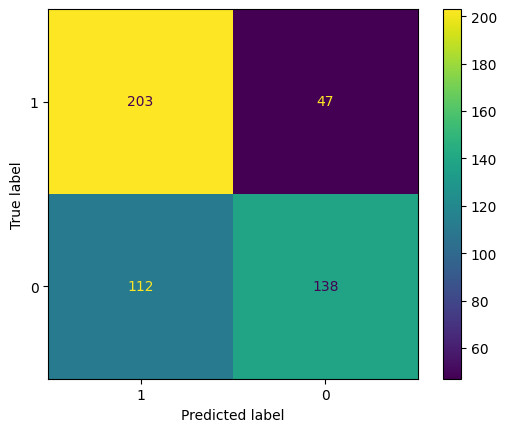

[inf  1.  0.]


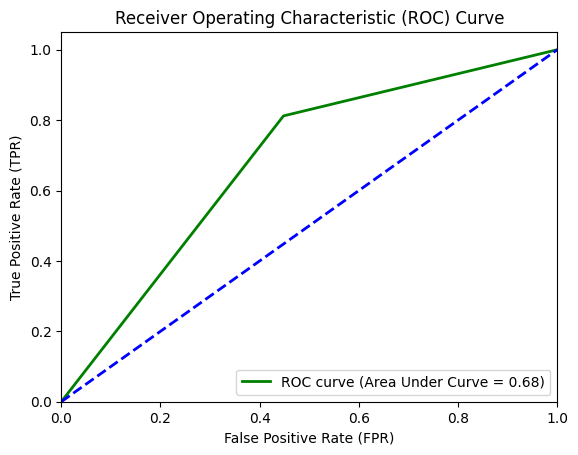

In [15]:
#performance report
performance(test_df['related_manual'],test_df['meanpooling_50'])

In [16]:
#initialise faiss model (embedding - last hidden state, number of samples - 50)
faiss_search_lh_50 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [17]:
#initialise corpus, by default last hidden state is used
%%time
faiss_search_lh_50.initialize_corpus(
    corpus=corpus_50,
    section='text'
    )

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 3min 35s, sys: 18.7 s, total: 3min 53s
Wall time: 28.2 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 50
})

In [18]:
#faiss prediction
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'lh_50'] = faiss_predict(item['tweet_original'], faiss_search_lh_50, fewshot_df_50)

CPU times: user 40min 5s, sys: 2min 34s, total: 42min 40s
Wall time: 4min 3s


Accuracy: 63.8%
[155  95  86 164]
TP: 155
FP: 86
TN: 164
FN: 95
Sensitivity: 62.0%
Specificity: 65.6%
Precision: 64.315%
Recall: 62.0%
f1: 63.136%


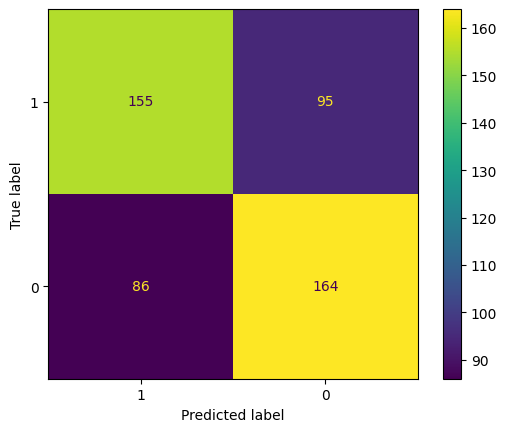

[inf  1.  0.]


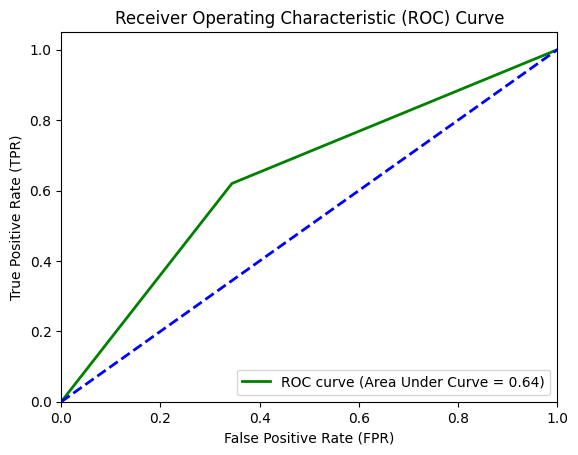

In [20]:
#performance report
performance(test_df['related_manual'],test_df['lh_50'])

<h2>100 examples<h2>

<h5> Now lets repeat the same experiment with 100 examples (50 from each class)

In [22]:
#initialise faiss model (embedding - mean pooling, number of samples - 100)
faiss_search_mean_100 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [23]:
corpus_100 = {'text':fewshot_df_100['tweet_original']}

In [24]:
#initialise corpus
%%time
faiss_search_mean_100.initialize_corpus(
    corpus=corpus_100,
    section='text', 
    embedding_type='mean_pooling',
    )

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 7min 16s, sys: 33.5 s, total: 7min 49s
Wall time: 48.9 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 100
})

In [25]:
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'meanpooling_100'] = faiss_predict(item['tweet_original'], faiss_search_mean_100, fewshot_df_100)

CPU times: user 36min 12s, sys: 2min 33s, total: 38min 46s
Wall time: 3min 46s


Accuracy: 74.4%
[235  15 113 137]
TP: 235
FP: 113
TN: 137
FN: 15
Sensitivity: 94.0%
Specificity: 54.8%
Precision: 67.529%
Recall: 94.0%
f1: 78.595%


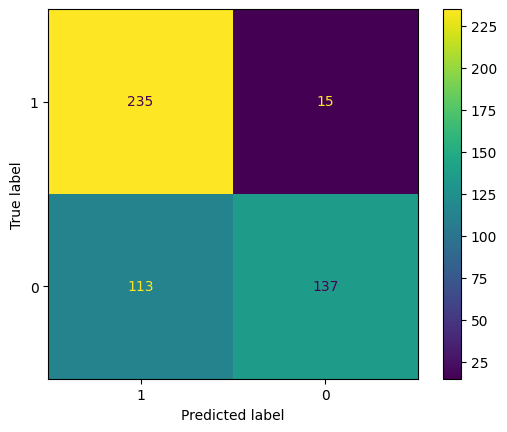

[inf  1.  0.]


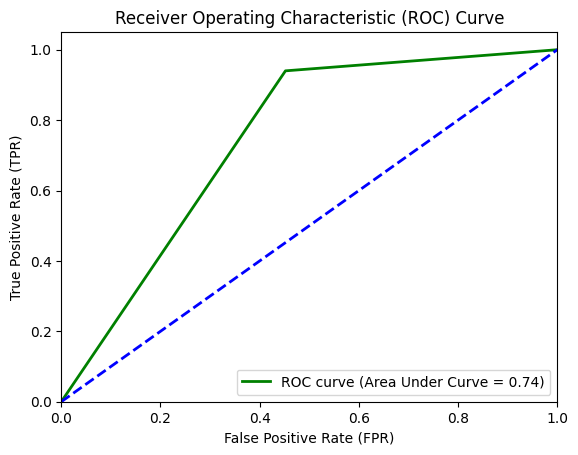

In [26]:
performance(test_df['related_manual'],test_df['meanpooling_100'])

In [27]:
#initialise faiss model (embedding - last hidden state, number of samples - 100)
faiss_search_lh_100 = FaissSearch(model_name_or_path = 'facebook/bart-large')

In [28]:
%%time
faiss_search_lh_100.initialize_corpus(
    corpus=corpus_100,
    section='text'
    )

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Adding FAISS index...


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 7min 32s, sys: 35.9 s, total: 8min 8s
Wall time: 52.3 s


Dataset({
    features: ['text', 'embeddings'],
    num_rows: 100
})

In [29]:
%%time
for index, item in test_df.iterrows():
    test_df.loc[index, 'lh_100'] = faiss_predict(item['tweet_original'], faiss_search_lh_100, fewshot_df_100)

CPU times: user 37min 26s, sys: 2min 41s, total: 40min 8s
Wall time: 3min 56s


Accuracy: 64.0%
[182  68 112 138]
TP: 182
FP: 112
TN: 138
FN: 68
Sensitivity: 72.8%
Specificity: 55.2%
Precision: 61.905%
Recall: 72.8%
f1: 66.912%


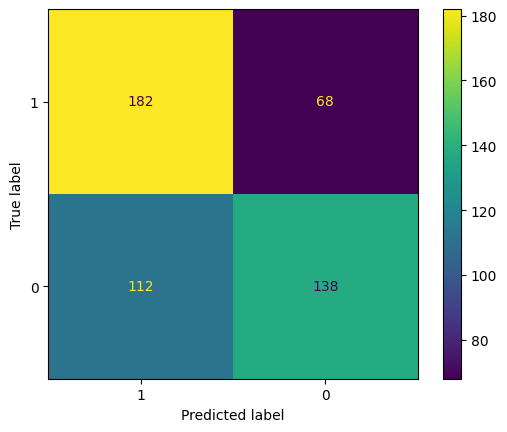

[inf  1.  0.]


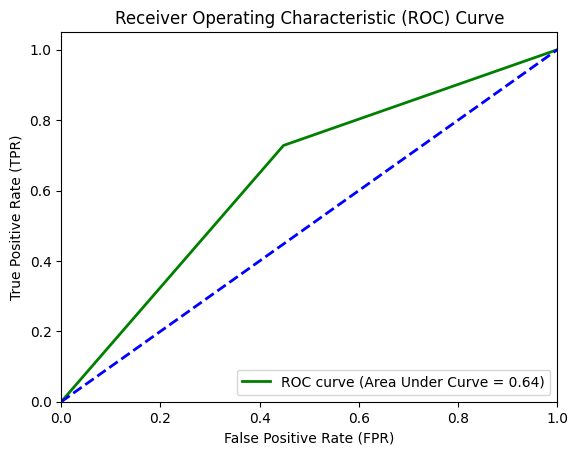

In [30]:
performance(test_df['related_manual'],test_df['lh_100'])

<h2>Results<h2>
<h5>The best performing model is the one which is trained with 100 examples and embedding type is mean pooling.

| Model            | Accuracy | TP  | FP  | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|------------------|----------|-----|-----|-----|----|-------------|-------------|-----------|--------|----------|
| Few shot (Faiss) | 74.4%    | 235 | 113 | 137 | 15 | 94.0%       | 54.8%       | 67.529%   | 94.0%  | 78.595%  |